In [ ]:
!nvidia-smi

Sun Aug 22 04:47:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import zipfile
import tensorflow as tf
import cv2
import random
import matplotlib.pyplot as plt
import os
from keras.callbacks import ReduceLROnPlateau
import matplotlib.image as mpimg
from tqdm import tqdm
 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
# boxes = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/dataset.npy',allow_pickle=True)
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/dataset.csv')
# !cp /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/dataset.zip /content/dataset.zip
# with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('/')
# !rm /content/dataset.zip

!cp /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/Cornell-dataset.zip /content/Cornell-dataset.zip
with zipfile.ZipFile('/content/Cornell-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cornell_grasping_dataset/')

In [4]:
# temptest = []
# for i in range(885):
#     for j in range(5):
#         temptest.append(f'/content/Dataset/im{i}_{random.randint(0,99)}.png')
 
# train = data[~data['path'].isin(temptest)].reset_index(drop=True)
# test = data[data['path'].isin(temptest)].reset_index(drop=True)
 
# train.to_csv('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/train.csv',index=False)
# test.to_csv('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/test.csv',index=False)
 
# del temptest
 
# train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/test.csv')


train = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/train.npy',allow_pickle=True)
test = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/test.npy',allow_pickle=True)

 
 
len(train),len(test)

(420375, 22125)

In [5]:
# class Dataset:
#     def __init__(self,df):
#         self.df = df.values
 
#     def __getitem__(self, i):
#         return tf.convert_to_tensor(cv2.imread(self.df[i,0])),tf.convert_to_tensor(np.round(self.df[i,1:].astype(float),2))
 
#     def __len__(self):
#         return len(self.df)
    
    
# class Dataloder(tf.keras.utils.Sequence):    
#     def __init__(self, dataset, batch_size=1):
#         self.dataset = dataset
#         self.batch_size = batch_size
#         self.indexes = np.arange(len(dataset))
 
#     def __getitem__(self, i):
        
#         # collect batch data
#         start = i * self.batch_size
#         stop = (i + 1) * self.batch_size
#         data = []
#         for j in range(start, stop):
#             data.append(self.dataset[j])
        
#         batch = [tf.stack(samples, axis=0) for samples in zip(*data)]
        
#         return tuple(batch)
    
#     def __len__(self):
#         return len(self.indexes) // self.batch_size
    
#     def on_epoch_end(self):
#         self.indexes = np.random.permutation(self.indexes)



class Dataset:
    def __init__(self,df):
        self.df = df


    def bboxes_to_grasps(self,box):
        # converting and scaling bounding boxes into grasps, g = {x, y, tan, h, w}
        x = (box[0][0] + (box[2][0] - box[0][0])/2)
        y = (box[0][1] + (box[2][1] - box[0][1])/2)
        tan =(box[2][0] -box[3][0]) / (box[2][1] -box[3][1])
        w = np.sqrt(np.power((box[1][0] - box[0][0]), 2) + np.power((box[1][1] -box[0][1]), 2))
        h = np.sqrt(np.power((box[3][0] -box[0][0]), 2) + np.power((box[3][1] -box[0][1]), 2))
        return round(x,3), round(y,3), 360 - (np.rad2deg(np.arctan(round(tan,3) )) + 90), round(h,3), round(w,3)

    # Reverse function
    def grasp_to_bbox_pred(self,x, y, angle, h, w):
        edge1 = (x - w/2, y + h/2)
        edge2 = (x + w/2, y + h/2)
        edge3 = (x + w/2, y - h/2)
        edge4 = (x - w/2, y - h/2)
        a = np.array([edge1, edge2, edge3, edge4])
        a = a - (x,y)
        angle = angle * (3.14/180)
        fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
        a = fun(a)
        a = np.array(a).T
        a = a + (x,y)
        return a

    def __getitem__(self, i):
        path = self.df[i][0]
        image=cv2.imread(path)
        box = self.df[i][7]


        # # random translating image
        height, width = image.shape[:2]
        tt,ttt =  self.df[i][4],self.df[i][5]
        T = np.float32([[1, 0, 50 * tt], [0, 1, 50 * ttt]])
        image = cv2.warpAffine(image, T, (width, height))

        # poin tranlation
        box = box + np.array([50 * tt,50 * ttt])

        # Rotate Image
        angle = self.df[i][6]
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

        # rotate point
        box = box - image_center
        angle = angle * -1
        angle = angle * (3.14/180)
        fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
        box = fun(box)
        box = np.array(box).T
        box = box + image_center
        

        x, y, tan, h, w = self.bboxes_to_grasps(box)

        return tf.convert_to_tensor(image),tf.convert_to_tensor(np.round(np.array([x, y, tan, h, w]),2))

    def __len__(self):
        return len(self.df)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(dataset))
 
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [6]:
def resenet_load():
    RESNET50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3), classes=2048)
    for i in range(len(RESNET50.layers)):
        RESNET50.layers[i].trainable = False
    return RESNET50

In [7]:
##Source: https://stackoverflow.com/a/57247833/8211103
from shapely.geometry import Polygon
def calculate_iou(data):
    box_1 = [[data[0],data[1]],[data[2],data[3]],[data[4],data[5]],[data[6],data[7]]]
    box_2 = [[data[8],data[9]],[data[10],data[11]],[data[12],data[13]],[data[14],data[15]]]
 
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = (poly_1.intersection(poly_2).area / poly_1.union(poly_2).area) * 100
    return np.ndarray.astype(np.array(iou),np.float32)
 
def grasp_to_bbox(x1, y1, tan1, h1, w1):
    lst = []
    
    fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
    for i in range(len(x1)):
        x = x1[i]
        y = y1[i]
        tan = tan1[i]
        h = h1[i]
        w = w1[i]
 
 
        angle = tan * (3.14/180)
        edge1 = (x - w/2, y + h/2)
        edge2 = (x + w/2, y + h/2)
        edge3 = (x + w/2, y - h/2)
        edge4 = (x - w/2, y - h/2)
 
        a = np.array([edge1, edge2, edge3, edge4])
        
        a = a - (x,y)
        a = fun(a)
        
        a = np.array(a).T
        
        a = a + (x,y)
        lst.append(a.reshape(1,-1)[0])
    return tf.convert_to_tensor(np.array(lst))
 
def Accuracy(y_train, y_pred):
    # a = tf.square(y_train[:,:2] - y_pred[:,:2])
    # a = tf.sqrt(tf.add(a[:,0], a[:,1]))
    # a = tf.cast(tf.less(a,10),tf.int8)
 
    b = tf.abs(y_train[:,2] - y_pred[:,2])
    b = tf.cast(tf.less(b,30),tf.int8)
    
 
    ## IOU
    f = tf.py_function(grasp_to_bbox,[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],Tout=tf.float32)
    f1 = tf.py_function(grasp_to_bbox,[y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4]],Tout=tf.float32)
 
 
    final = tf.concat([f, f1],axis=1)
    fun = lambda x : tf.py_function(calculate_iou,[x],Tout=tf.float32)
    iou = tf.map_fn(fun, final)
    iou = tf.cast(tf.greater(iou,25),tf.int8)
    
 
    # score = tf.reduce_mean(tf.add(tf.add(a,b),iou)/3)
    score = tf.reduce_mean(tf.add(b,iou)/2)
 
    return score
 
def get_model(lr = 0.001):
    input = tf.keras.layers.Input((320,320,3,))
    resnet = RESNET50(input)
    x = tf.keras.layers.Flatten()(resnet)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(5)(x)
    model = tf.keras.models.Model(input,output)
 
    model.compile(tf.keras.optimizers.Adam(lr), loss = 'mse')
    return model

In [ ]:
BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)
 
RESNET50 = resenet_load()
model = get_model()
 
filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')
 
model.fit(train_dataloader,epochs=10,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
3284/3284 [==============================] - 3461s 1s/step - loss: 1084.3735 - val_loss: 490.6335

Epoch 00001: val_loss improved from inf to 490.63348, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
3284/3284 [==============================] - 3401s 1s/step - loss: 680.8790 - val_loss: 382.7492

Epoch 00002: val_loss improved from 490.63348 to 382.74918, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
3284/3284 [==============================] - 3412s 1s/step - loss: 610.7713 - val_loss: 331.7876

Epoch 00003: val_loss improved from 382.74918 to 331.78757, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/10
3284/3284 [==============================] - 3405s 1s/step - loss: 566.4801 - val_loss: 306.1539

Epoch 00004: val_loss improved from 331.78757 to 306.15390, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
3284/3284 [==============================] - 3561s 1s/step - loss: 538.4371 - val_loss: 293.0016

Epoch 00005: val_loss improved from 306.15390 to 293.00165, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/10
3284/3284 [==============================] - 3555s 1s/step - loss: 517.4422 - val_loss: 274.7605

Epoch 00006: val_loss improved from 293.00165 to 274.76053, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/10
3284/3284 [==============================] - 3542s 1s/step - loss: 499.1938 - val_loss: 253.6020

Epoch 00007: val_loss improved from 274.76053 to 253.60204, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10
3284/3284 [==============================] - 3560s 1s/step - loss: 484.7195 - val_loss: 258.5255

Epoch 00008: val_loss did not improve from 253.60204
Epoch 9/10
3284/3284 [==============================] - 3466s 1s/step - loss: 472.0705 - val_loss: 266.9972

Epoch 00009: val_loss did not improve from 253.60204
Epoch 10/10
3284/3284 [==============================] - 3501s 1s/step - loss: 462.7178 - val_loss: 228.5976

Epoch 00010: val_loss improved from 253.60204 to 228.59761, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
RESNET50 = resenet_load()
model = get_model()
filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model.load_weights(filepath)


BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)

filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')

model.fit(train_dataloader,epochs=7,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/7
3284/3284 [==============================] - 3943s 1s/step - loss: 473.3393 - val_loss: 235.1683

Epoch 00001: val_loss improved from inf to 235.16830, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
3284/3284 [==============================] - 3880s 1s/step - loss: 462.8927 - val_loss: 266.7746

Epoch 00002: val_loss did not improve from 235.16830
Epoch 3/7
3284/3284 [==============================] - 3868s 1s/step - loss: 454.3499 - val_loss: 226.5065

Epoch 00003: val_loss improved from 235.16830 to 226.50647, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/7
3284/3284 [==============================] - 3909s 1s/step - loss: 444.6586 - val_loss: 238.7166

Epoch 00004: val_loss did not improve from 226.50647
Epoch 5/7
3284/3284 [==============================] - 3879s 1s/step - loss: 436.6931 - val_loss: 222.0782

Epoch 00005: val_loss improved from 226.50647 to 222.07817, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/7
3284/3284 [==============================] - 3913s 1s/step - loss: 429.6583 - val_loss: 219.9567

Epoch 00006: val_loss improved from 222.07817 to 219.95674, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/7
3284/3284 [==============================] - 3934s 1s/step - loss: 423.1915 - val_loss: 232.6874

Epoch 00007: val_loss did not improve from 219.95674


In [ ]:
RESNET50 = resenet_load()
model = get_model()
filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model.load_weights(filepath)


BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)


filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2,verbose = 2, min_delta = 1e-4, mode = 'min')

model.fit(train_dataloader,epochs=8,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/8
3284/3284 [==============================] - 3430s 1s/step - loss: 425.2571 - val_loss: 247.9125

Epoch 00001: val_loss improved from inf to 247.91249, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
3284/3284 [==============================] - 3406s 1s/step - loss: 419.6971 - val_loss: 201.8478

Epoch 00002: val_loss improved from 247.91249 to 201.84776, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/8
3284/3284 [==============================] - 3465s 1s/step - loss: 412.3322 - val_loss: 197.0184

Epoch 00003: val_loss improved from 201.84776 to 197.01836, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/8
3284/3284 [==============================] - 3388s 1s/step - loss: 409.5670 - val_loss: 215.5986

Epoch 00004: val_loss did not improve from 197.01836
Epoch 5/8
3284/3284 [==============================] - 3314s 1s/step - loss: 403.5405 - val_loss: 242.9568

Epoch 00005: val_loss did not improve from 197.01836

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/8
3284/3284 [==============================] - 3316s 1s/step - loss: 353.2256 - val_loss: 153.6987

Epoch 00006: val_loss improved from 197.01836 to 153.69875, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/8
3284/3284 [==============================] - 3429s 1s/step - loss: 345.6337 - val_loss: 155.7741

Epoch 00007: val_loss did not improve from 153.69875
Epoch 8/8
3284/3284 [==============================] - 3321s 1s/step - loss: 342.6229 - val_loss: 150.3121

Epoch 00008: val_loss improved from 153.69875 to 150.31207, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
RESNET50 = resenet_load()
model = get_model(0.00020000000949949026)
filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model.load_weights(filepath)


BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)


filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2,verbose = 2, min_delta = 1e-4, mode = 'min')

model.fit(train_dataloader,epochs=5,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/5
3284/3284 [==============================] - 3953s 1s/step - loss: 339.7351 - val_loss: 149.3396

Epoch 00001: val_loss improved from inf to 149.33965, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
3284/3284 [==============================] - 3897s 1s/step - loss: 337.1874 - val_loss: 166.0727

Epoch 00002: val_loss did not improve from 149.33965
Epoch 3/5
3284/3284 [==============================] - 3858s 1s/step - loss: 335.6989 - val_loss: 147.3706

Epoch 00003: val_loss improved from 149.33965 to 147.37061, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
3284/3284 [==============================] - 3922s 1s/step - loss: 334.1394 - val_loss: 151.8752

Epoch 00004: val_loss did not improve from 147.37061
Epoch 5/5
3284/3284 [==============================] - 3868s 1s/step - loss: 332.2014 - val_loss: 143.5803

Epoch 00005: val_loss improved from 147.37061 to 143.58029, saving model to /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
def calculate_iou(data):
    box_1 = [[data[0],data[1]],[data[2],data[3]],[data[4],data[5]],[data[6],data[7]]]
    box_2 = [[data[8],data[9]],[data[10],data[11]],[data[12],data[13]],[data[14],data[15]]]
 
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = (poly_1.intersection(poly_2).area / poly_1.union(poly_2).area) * 100
    return np.ndarray.astype(np.array(iou),np.float32)

def Accuracy(y_train, y_pred):
    # a = tf.square(y_train[:,:2] - y_pred[:,:2])
    # a = tf.sqrt(tf.add(a[:,0], a[:,1]))
    # a = tf.cast(tf.less(a,10),tf.int8)
 
    b = tf.abs(y_train[:,2] - y_pred[:,2])
    b = tf.cast(tf.less(b,30),tf.int8).numpy().reshape(-1,1)
    
    
    ## IOU
    f = grasp_to_bbox(y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4])
    f1 = grasp_to_bbox(y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4])
 
 
    final = tf.concat([f, f1],axis=1).numpy()
    iou = []
    for row in final:
        if calculate_iou(row) >25:
            iou.append(1)
        else:
            iou.append(0)
    iou = np.array(iou).reshape(-1,1)

    score = np.mean(np.sum(np.concatenate([b,iou],axis = 1),axis = 1)/2)
    return score

def score(train_dataloader):
    score = []
    for i in tqdm(range(len(train_dataloader))):
        y_pred = model.predict(train_dataloader[0][0])
        y_train =  train_dataloader[0][1]
        score.append(Accuracy(y_train, y_pred))
    return np.mean(score)

In [8]:
BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)

RESNET50 = resenet_load()
model = get_model()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/Models/RESNET50.h5")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
score(test_dataloader)

100%|██████████| 172/172 [06:22<00:00,  2.23s/it]


0.89453125

In [ ]:
score(train_dataloader)

100%|██████████| 3284/3284 [1:54:24<00:00,  2.09s/it]


0.90625

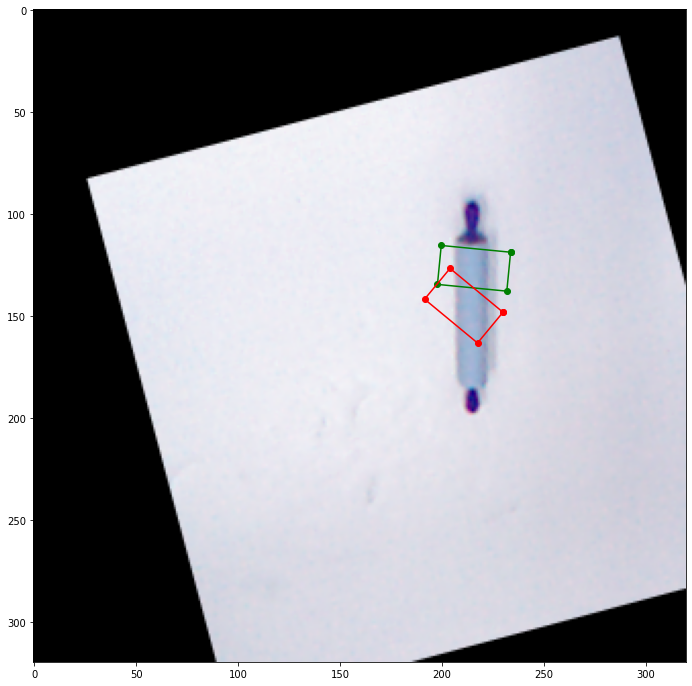

In [52]:
test_dataloader.batch_size = 1
i = random.randint(0,128)
act = test_dataloader[i][1][0]
pred = model.predict(test_dataloader[i][0])[0]
act_image = (test_dataloader[i][0][0])
 
def grasp_to_bbox_pred(x, y, angle, h, w):
    edge1 = (x - w/2, y + h/2)
    edge2 = (x + w/2, y + h/2)
    edge3 = (x + w/2, y - h/2)
    edge4 = (x - w/2, y - h/2)
    a = np.array([edge1, edge2, edge3, edge4])
    a = a - (x,y)
    angle = angle * (3.14/180)
    fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
    a = fun(a)
    a = np.array(a).T
    a = a + (x,y)
    return a
 
x, y, tan, h, w = act[0],act[1],act[2],act[3],act[4]
edges = grasp_to_bbox_pred(x, y, tan, h, w)
 
x = edges[:,0].reshape(1,-1)[0]
y = edges[:,1].reshape(1,-1)[0]
 
x = np.concatenate([x,x[:1]])
y = np.concatenate([y,y[:1]])
 
im = act_image
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(im)
ax.plot(x,y, 'ro-',color = 'green')
 
 
x, y, tan, h, w = pred[0],pred[1],pred[2],pred[3],pred[4]
edges = grasp_to_bbox_pred(x, y, tan, h, w)
 
x = edges[:,0].reshape(1,-1)[0]
y = edges[:,1].reshape(1,-1)[0]
 
x = np.concatenate([x,x[:1]])
y = np.concatenate([y,y[:1]])
 
 
ax.plot(x,y, 'ro-')
 
plt.show()

plt.imsave("temp.png",test_dataset[i][0].numpy())

In [ ]:
RESNET50 = resenet_load()
model = get_model()
filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50.ckpt"
model.load_weights(filepath)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
!mkdir /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/Models
model.save_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/Models/RESNET50.h5")

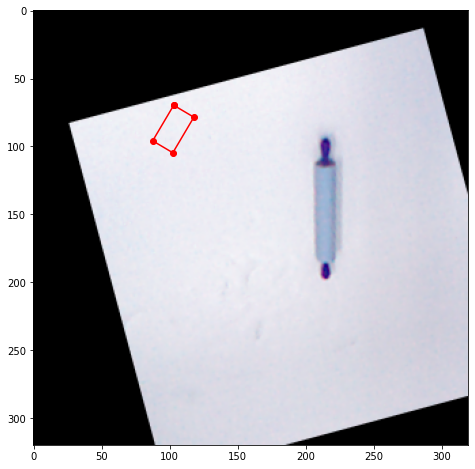

In [61]:
im = cv2.imread('/content/temp.png',cv2.IMREAD_COLOR)
im = plt.imread('/content/temp.png')[:,:,:3]
pred = model.predict(np.array([im]))[0]
x, y, tan, h, w = pred[0],pred[1],pred[2],pred[3],pred[4]
edges = grasp_to_bbox_pred(x, y, tan, h, w)
 
x = edges[:,0].reshape(1,-1)[0] 
y = edges[:,1].reshape(1,-1)[0] 
 
x = np.concatenate([x,x[:1]])
y = np.concatenate([y,y[:1]])
 

fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(im) 
ax.plot(x,y, 'ro-')